# Import

In [1]:
import sys
sys.path.append('../src/')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import joblib
from sklearn.metrics import pairwise_distances
from PIL import Image
from sklearn.metrics import pairwise_distances
from sklearn.cluster import Birch

from DataSetFactory import DataSetFactory
from AMAP import AMAP

In [2]:
RANDOM_STATE = 42

In [3]:
ds = DataSetFactory.get_dataset('vgg_features_imagenet', RANDOM_STATE ,sample=0.15)

(7890, 4097) 7890
Taking sample of 0.15 from the data


In [4]:
X = ds.df[ds.feature_cols].values
y = ds.df[ds.label_col].values

In [7]:
ds.class_to_label

{0: 'Norwegian_elkhound',
 1: 'golden_retriever',
 2: 'Maltese_dog',
 3: 'Scottish_deerhound',
 4: 'Bedlington_terrier',
 5: 'Blenheim_spaniel',
 6: 'Boston_bull',
 7: 'toy_terrier',
 8: 'Rhodesian_ridgeback',
 9: 'Afghan_hound'}

In [5]:
dist_mat = pairwise_distances(X)

In [6]:
dist_mat.shape

(1184, 1184)

In [7]:
threshold_candidates = np.unique(dist_mat)

In [8]:
threshold_candidates.shape

(670688,)

In [9]:
# for the sake of the experiment let's evaluate all of them
thresholds_df = pd.DataFrame(threshold_candidates, columns=['threshold'])
thresholds_df['num_clusters'] = np.nan
thresholds_df['num_points'] = ds.df.shape[0]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017B474A6808>]],
      dtype=object)

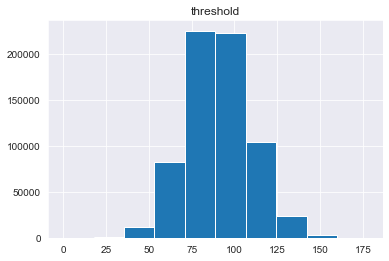

In [10]:
thresholds_df.hist(['threshold'])

In [11]:
# Filter only thresholds smaller than 1.5
thresholds_df_sample = thresholds_df[thresholds_df['threshold']<=70]
thresholds_df_sample = thresholds_df_sample.sample(n=200, random_state=RANDOM_STATE)
# thresholds_df_sample = thresholds_df.sample(n=200, random_state=RANDOM_STATE)

In [12]:
def get_num_clusters_birch(ds, threshold):
    num_clusters = 0
    for label in ds.df[ds.label_col].unique():
        label_data = ds.df[ds.df[ds.label_col]==label][ds.feature_cols].values
        birch = Birch(threshold=threshold, branching_factor=2, n_clusters=None)
        birch.fit(label_data)
        num_clusters += birch.subcluster_centers_.shape[0]
    return num_clusters

thresholds_df_sample['num_clusters'] = thresholds_df_sample['threshold'].transform(lambda t: get_num_clusters_birch(ds, t))
thresholds_df_sample['compression'] = thresholds_df_sample['num_points'] / thresholds_df_sample['num_clusters']

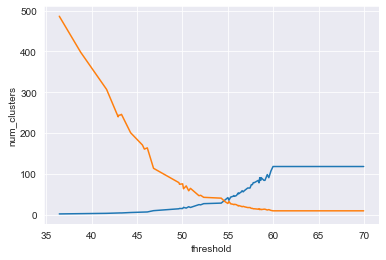

In [13]:
sns.lineplot(x='threshold', y='compression', data=thresholds_df_sample)
sns.lineplot(x='threshold', y='num_clusters', data=thresholds_df_sample)

# PCA

In [14]:
pca_amap = AMAP(dim_reduction_algo='pca',
                 birch_threshold=35,
                 reduce_all_points=True,
                 n_iter=1, 
                 batch_size=0,
                 learning_rate=0.1,
                 do_animation=False,
                 dataset='VGGAnimals',
                 class_to_label=ds.class_to_label,
                 show_fig=True,
                 save_fig=True,
                 random_state=RANDOM_STATE,
                 show_anchors=False,
                 supervised=False,
                 show_points=True,
                 show_inner_blobs=False,
                 show_polygons=False,
                 show_label_level_plots=True,
                 show_anchor_level_plot=False,
                 annotate_images=False,
                 only_inter_relations=True)
print(pca_amap)

AMAP
addr:@fa5488
verbose=True
n_components=2
anchors_method='birch'
n_intra_anchors=None
birch_threshold=35
birch_branching_factor=None
dim_reduction_algo='pca'
supervised=False
umap_n_neighbors=15
umap_min_dist=1
reduce_all_points=True
uniform_points_per='anchor'
k=20
proximity_k=3
self_relation=False
radius_q=None
do_relaxation=True
top_greedy=1
magnitude_step=False
n_iter=1
batch_size=0
stop_criteria=1e-05
loss_func=<function AMAP.l_inf_loss at 0x0000017B47537EE8>
loss='Linf'
only_inter_relations=True
learning_rate=0.1
mask_sparse_subcluster=None
random_points_method='voronoi'
class_to_label={0: 'Norwegian_elkhound', 1: 'golden_retriever', 2: 'Maltese_dog', 3: 'Scottish_deerhound', 4: 'Bedlington_terrier', 5: 'Blenheim_spaniel', 6: 'Boston_bull', 7: 'toy_terrier', 8: 'Rhodesian_ridgeback', 9: 'Afghan_hound'}
random_state=42
n_jobs=None
dataset='VGGAnimals'
show_fig=True
save_fig=True
is_plotly=False
do_animation=False
use_spline=False
alpha=None
douglas_peucker_tolerance=0.6
smooth

finding intra class anchors using birch
UnSupervised Dim Reduction
Dim Reduction all points
Starting iteration 1 loss = 1.0


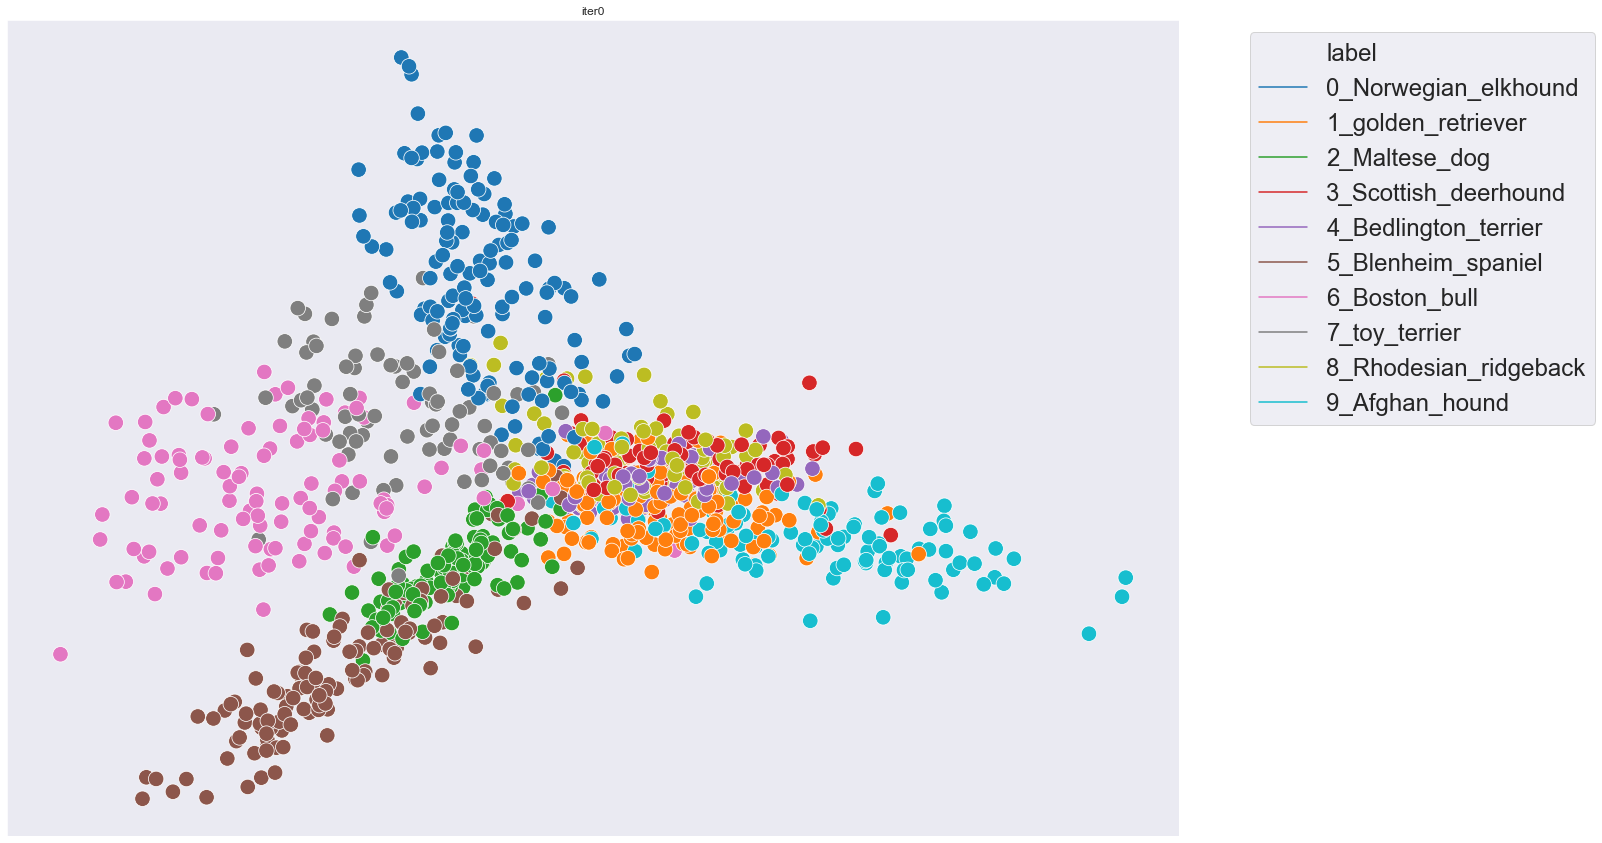

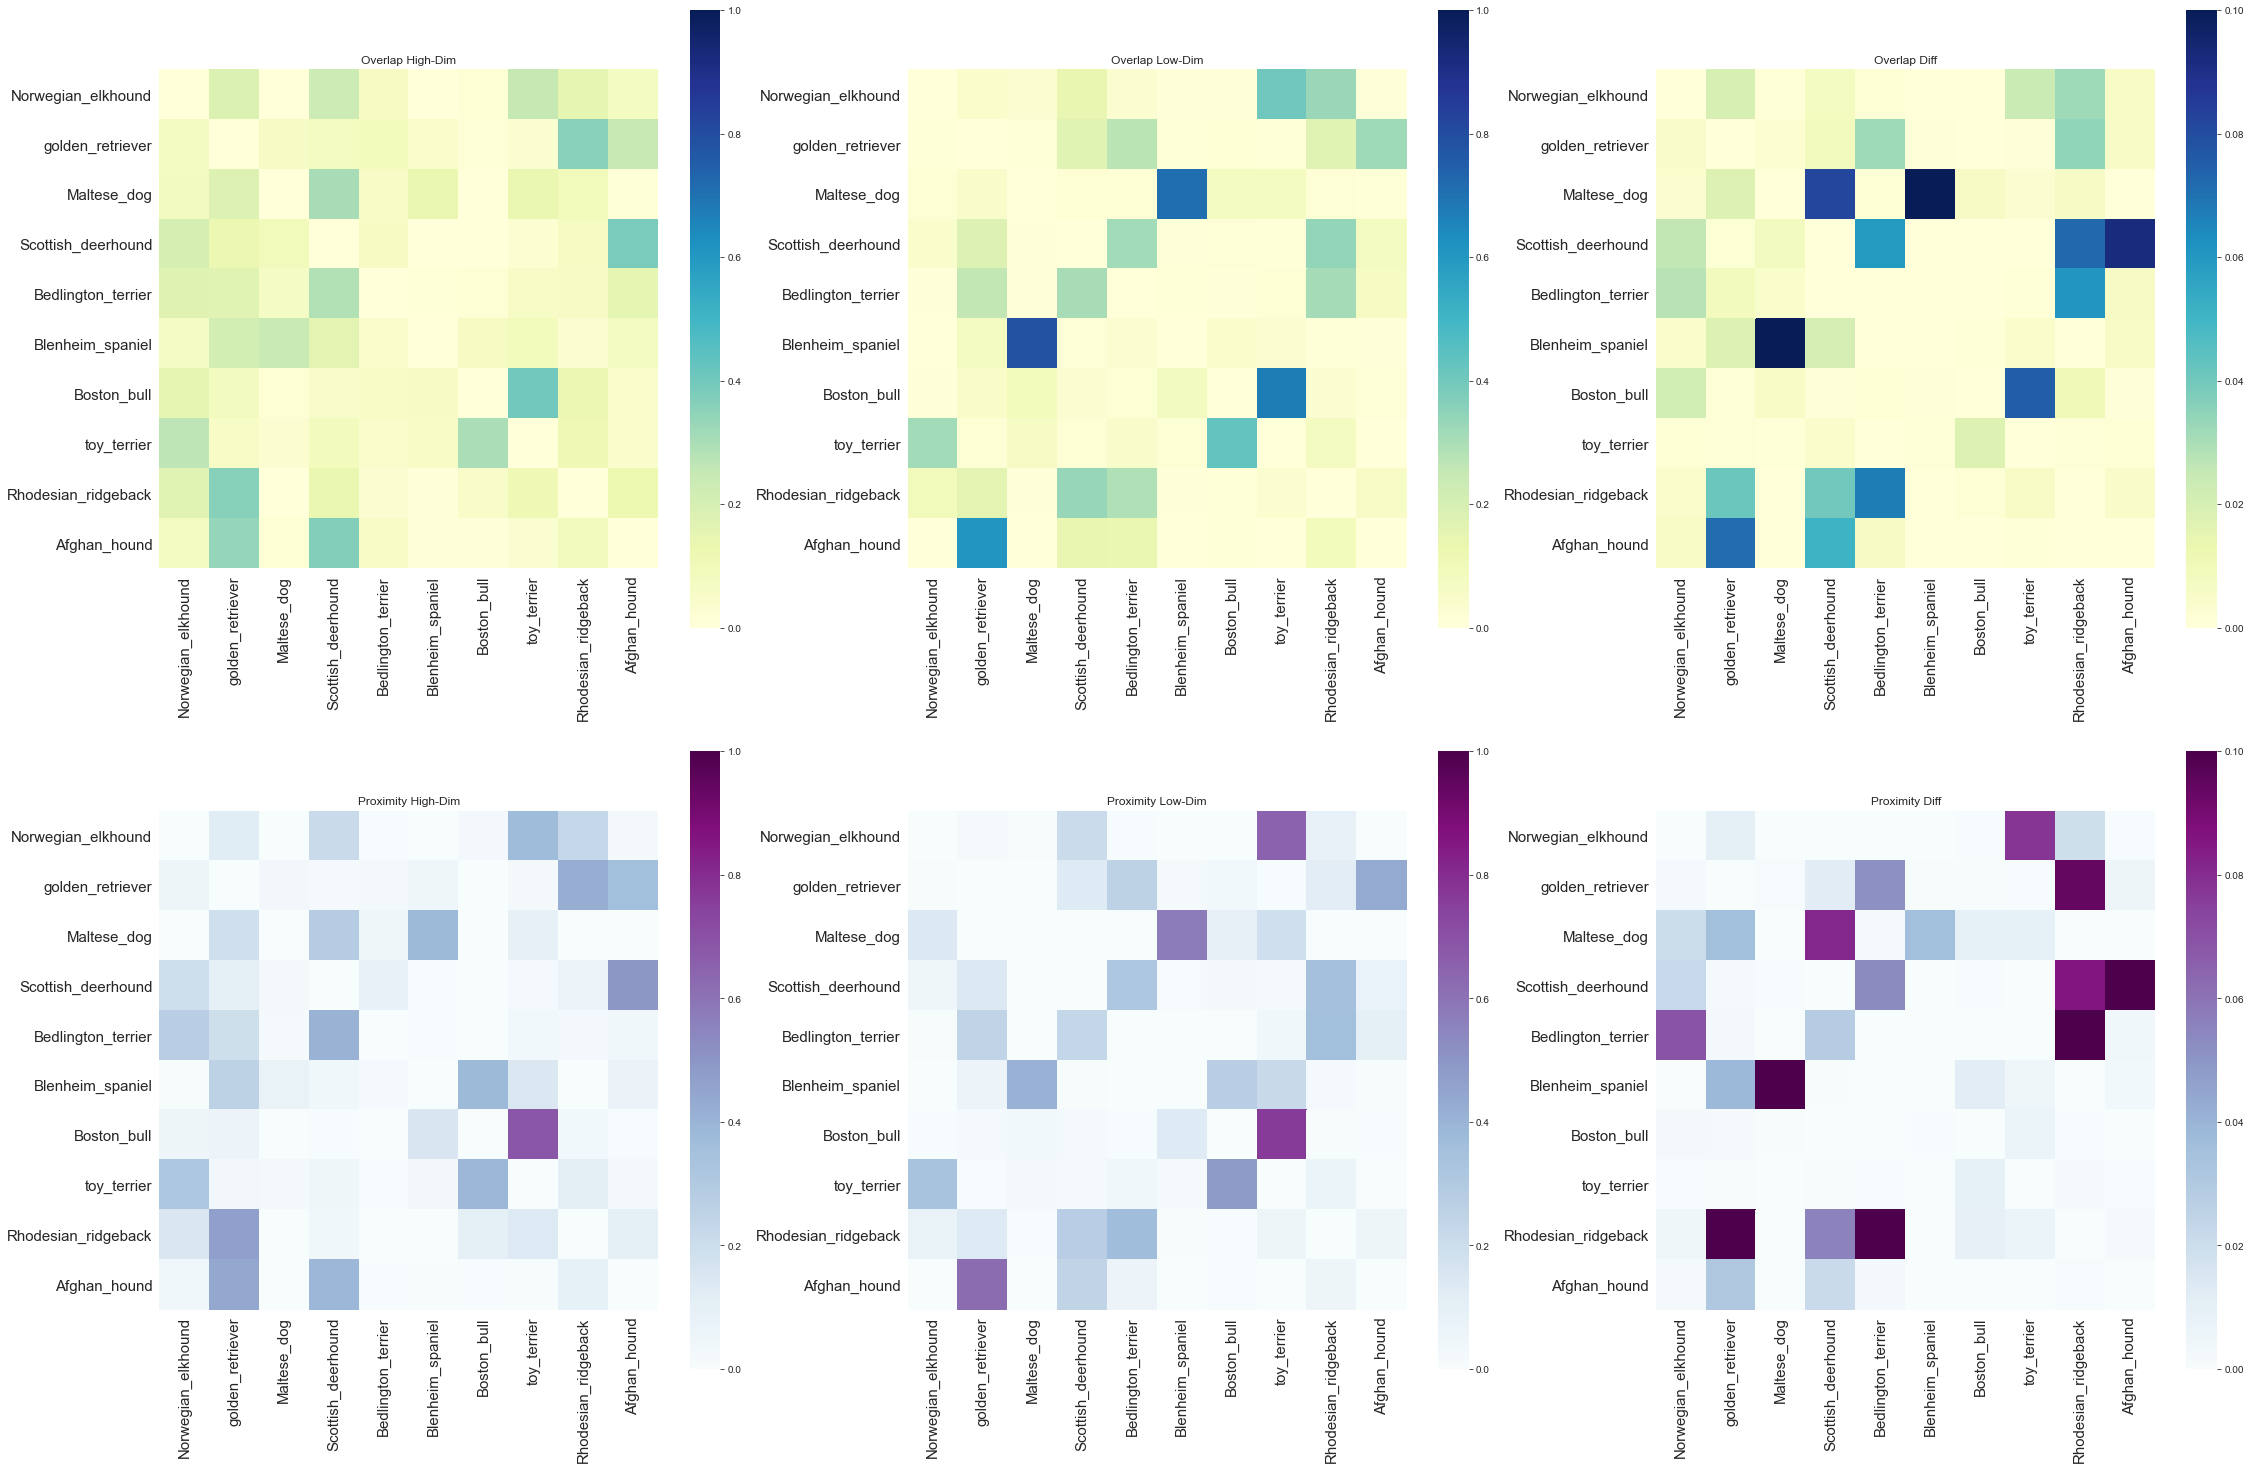

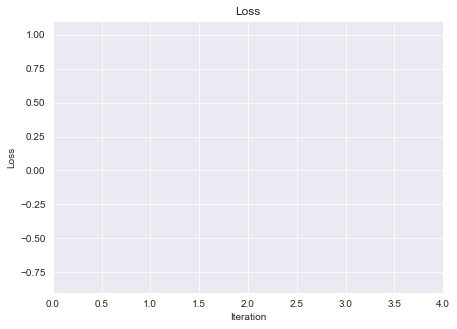

In [15]:
low_dim_pca = pca_amap.fit_transform(X,y)

# Supervised UMAP

In [16]:
sumap_amap = AMAP(dim_reduction_algo='umap',
                 birch_threshold=35,
                 reduce_all_points=True,
                 n_iter=1, 
                 batch_size=0,
                 learning_rate=0.1,
                 do_animation=False,
                 dataset='VGGAnimals',
                 class_to_label=ds.class_to_label,
                 show_fig=True,
                 save_fig=True,
                 random_state=RANDOM_STATE,
                 show_anchors=False,
                 supervised=True,
                 show_points=True,
                 show_inner_blobs=False,
                 show_polygons=False,
                 show_label_level_plots=False,
                 show_anchor_level_plot=False,
                 annotate_images=False,
                 only_inter_relations=True)
print(sumap_amap)

AMAP
addr:@daec8
verbose=True
n_components=2
anchors_method='birch'
n_intra_anchors=None
birch_threshold=35
birch_branching_factor=None
dim_reduction_algo='umap'
supervised=True
umap_n_neighbors=15
umap_min_dist=1
reduce_all_points=True
uniform_points_per='anchor'
k=20
proximity_k=3
self_relation=False
radius_q=None
do_relaxation=True
top_greedy=1
magnitude_step=False
n_iter=1
batch_size=0
stop_criteria=1e-05
loss_func=<function AMAP.l_inf_loss at 0x0000017B47537EE8>
loss='Linf'
only_inter_relations=True
learning_rate=0.1
mask_sparse_subcluster=None
random_points_method='voronoi'
class_to_label={0: 'Norwegian_elkhound', 1: 'golden_retriever', 2: 'Maltese_dog', 3: 'Scottish_deerhound', 4: 'Bedlington_terrier', 5: 'Blenheim_spaniel', 6: 'Boston_bull', 7: 'toy_terrier', 8: 'Rhodesian_ridgeback', 9: 'Afghan_hound'}
random_state=42
n_jobs=None
dataset='VGGAnimals'
show_fig=True
save_fig=True
is_plotly=False
do_animation=False
use_spline=False
alpha=None
douglas_peucker_tolerance=0.6
smooth_

finding intra class anchors using birch
Supervised Dim Reduction
Dim Reduction all points
Starting iteration 1 loss = 1.0


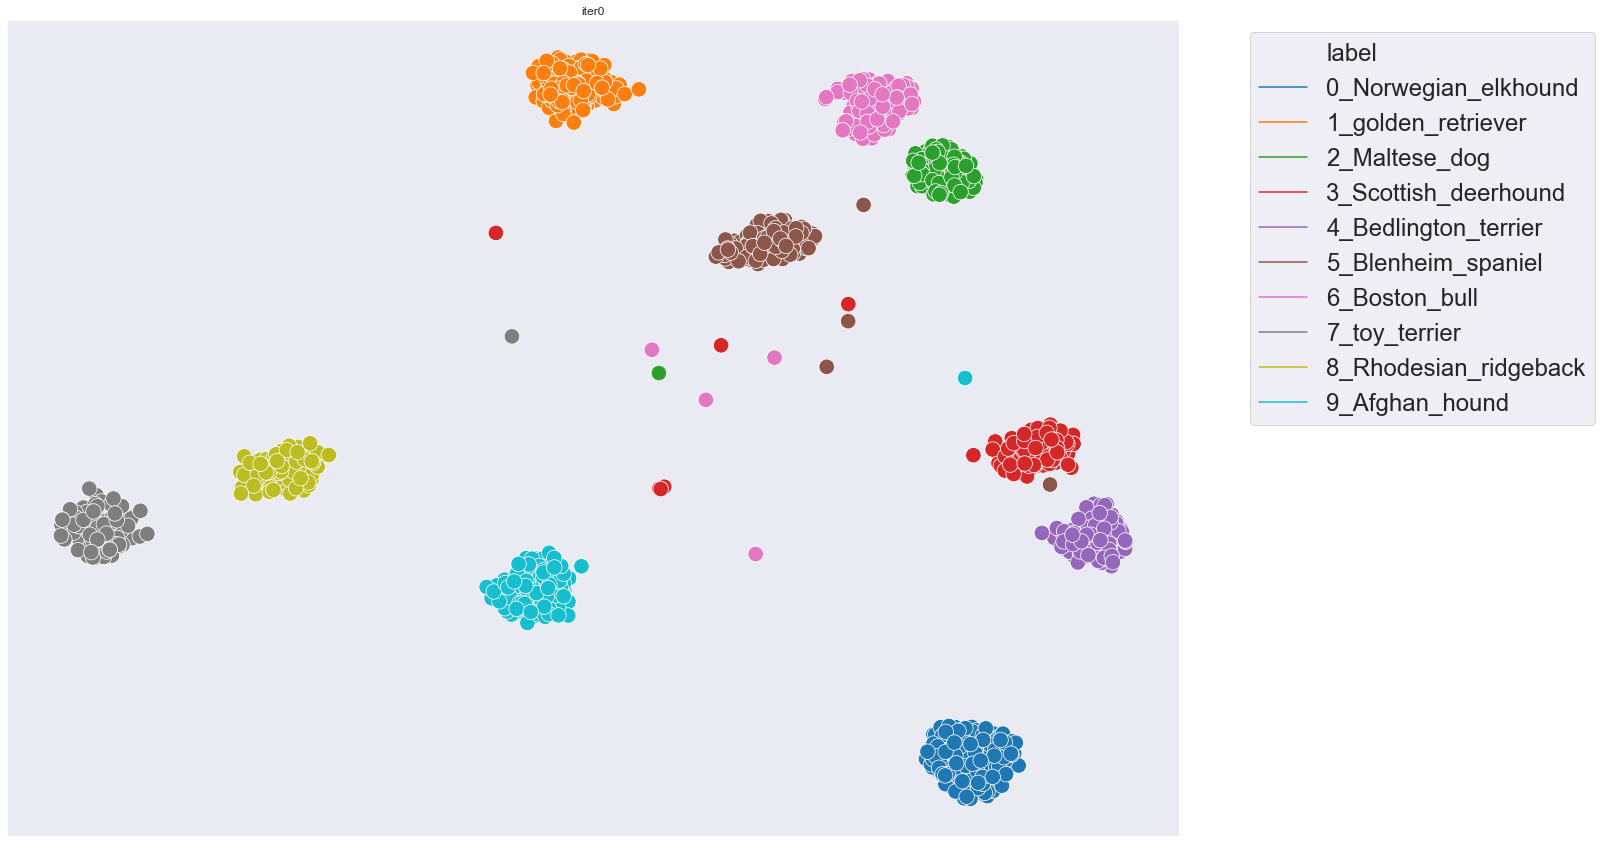

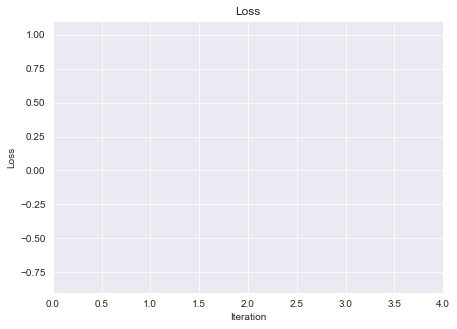

In [17]:
sumap_low_dim = sumap_amap.fit_transform(X,y)

# UNSUPERVISED UMAP

In [18]:
umap_amap = AMAP(dim_reduction_algo='umap',
                 birch_threshold=35,
                 reduce_all_points=True,
                 n_iter=1, 
                 batch_size=0,
                 learning_rate=0.1,
                 do_animation=False,
                 dataset='VGGAnimals',
                 class_to_label=ds.class_to_label,
                 show_fig=True,
                 save_fig=True,
                 random_state=RANDOM_STATE,
                 show_anchors=False,
                 supervised=False,
                 show_points=True,
                 show_inner_blobs=False,
                 show_polygons=False,
                 show_label_level_plots=False,
                 show_anchor_level_plot=False,
                 annotate_images=False,
                 only_inter_relations=True)
print(umap_amap)

AMAP
addr:@326088
verbose=True
n_components=2
anchors_method='birch'
n_intra_anchors=None
birch_threshold=35
birch_branching_factor=None
dim_reduction_algo='umap'
supervised=False
umap_n_neighbors=15
umap_min_dist=1
reduce_all_points=True
uniform_points_per='anchor'
k=20
proximity_k=3
self_relation=False
radius_q=None
do_relaxation=True
top_greedy=1
magnitude_step=False
n_iter=1
batch_size=0
stop_criteria=1e-05
loss_func=<function AMAP.l_inf_loss at 0x0000017B47537EE8>
loss='Linf'
only_inter_relations=True
learning_rate=0.1
mask_sparse_subcluster=None
random_points_method='voronoi'
class_to_label={0: 'Norwegian_elkhound', 1: 'golden_retriever', 2: 'Maltese_dog', 3: 'Scottish_deerhound', 4: 'Bedlington_terrier', 5: 'Blenheim_spaniel', 6: 'Boston_bull', 7: 'toy_terrier', 8: 'Rhodesian_ridgeback', 9: 'Afghan_hound'}
random_state=42
n_jobs=None
dataset='VGGAnimals'
show_fig=True
save_fig=True
is_plotly=False
do_animation=False
use_spline=False
alpha=None
douglas_peucker_tolerance=0.6
smoot

finding intra class anchors using birch
UnSupervised Dim Reduction
Dim Reduction all points
Starting iteration 1 loss = 1.0


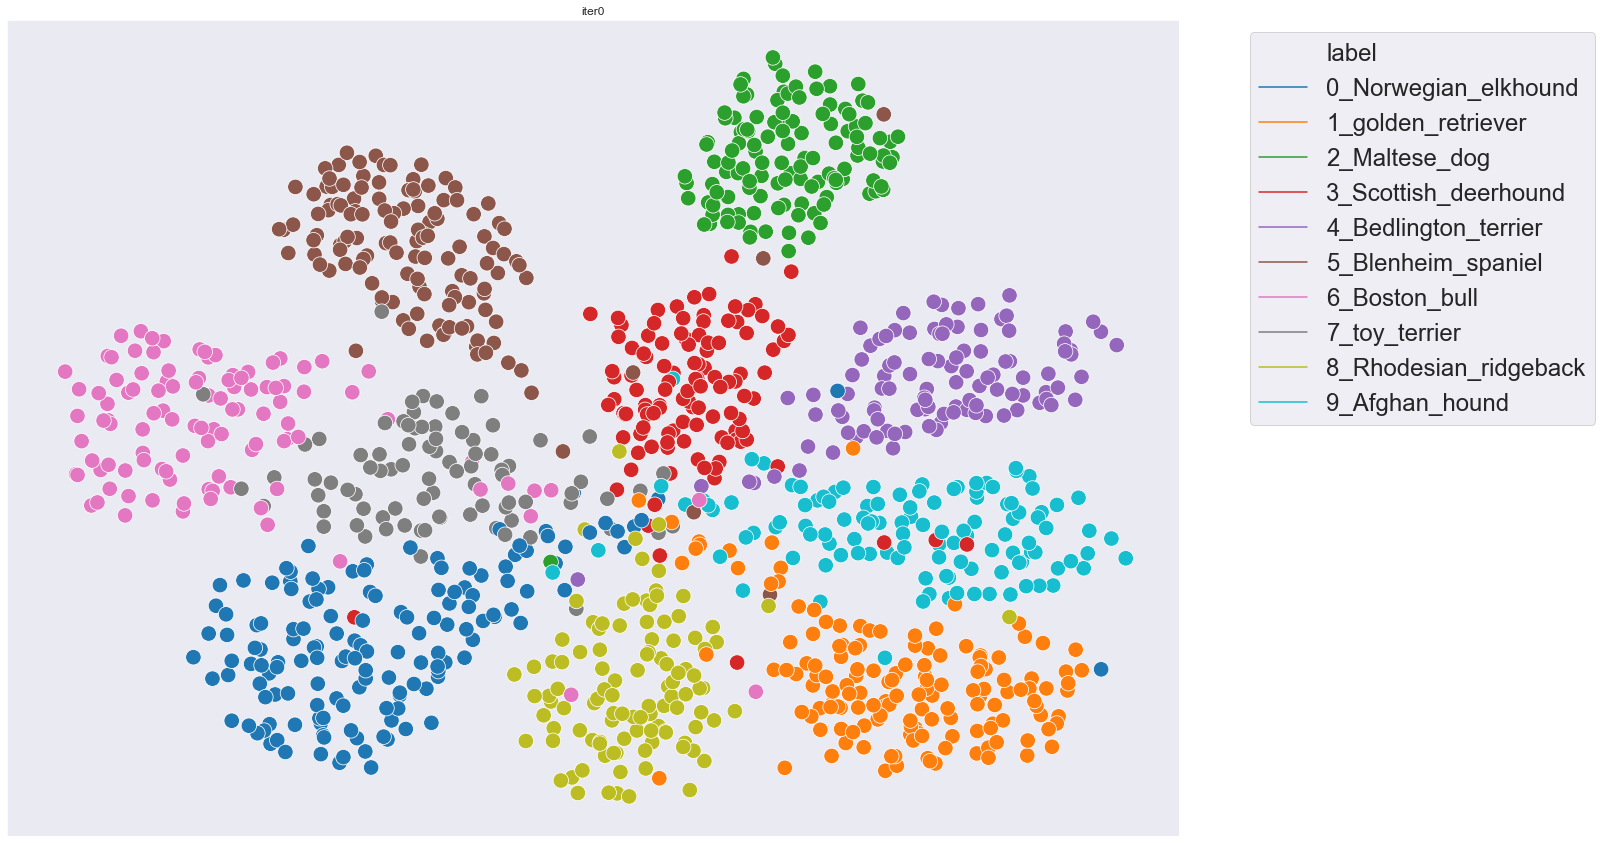

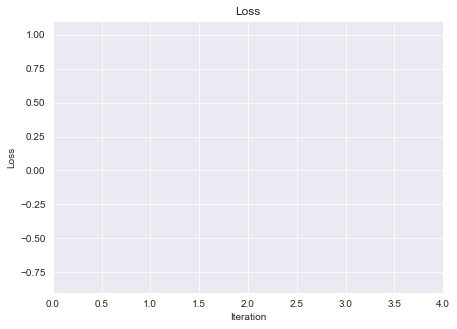

In [19]:
umap_low_dim = umap_amap.fit_transform(X,y)

# T-SNE

In [20]:
tsne_amap = AMAP(dim_reduction_algo='t-sne',
                 birch_threshold=35,
                 reduce_all_points=True,
                 n_iter=1, 
                 batch_size=0,
                 learning_rate=0.1,
                 do_animation=False,
                 dataset='VGGAnimals',
                 class_to_label=ds.class_to_label,
                 show_fig=True,
                 save_fig=True,
                 random_state=RANDOM_STATE,
                 show_anchors=False,
                 supervised=False,
                 show_points=True,
                 show_inner_blobs=False,
                 show_polygons=False,
                 show_label_level_plots=False,
                 show_anchor_level_plot=False,
                 annotate_images=False,
                 only_inter_relations=True)
print(tsne_amap)

AMAP
addr:@2fca48
verbose=True
n_components=2
anchors_method='birch'
n_intra_anchors=None
birch_threshold=35
birch_branching_factor=None
dim_reduction_algo='t-sne'
supervised=False
umap_n_neighbors=15
umap_min_dist=1
reduce_all_points=True
uniform_points_per='anchor'
k=20
proximity_k=3
self_relation=False
radius_q=None
do_relaxation=True
top_greedy=1
magnitude_step=False
n_iter=1
batch_size=0
stop_criteria=1e-05
loss_func=<function AMAP.l_inf_loss at 0x0000017B47537EE8>
loss='Linf'
only_inter_relations=True
learning_rate=0.1
mask_sparse_subcluster=None
random_points_method='voronoi'
class_to_label={0: 'Norwegian_elkhound', 1: 'golden_retriever', 2: 'Maltese_dog', 3: 'Scottish_deerhound', 4: 'Bedlington_terrier', 5: 'Blenheim_spaniel', 6: 'Boston_bull', 7: 'toy_terrier', 8: 'Rhodesian_ridgeback', 9: 'Afghan_hound'}
random_state=42
n_jobs=None
dataset='VGGAnimals'
show_fig=True
save_fig=True
is_plotly=False
do_animation=False
use_spline=False
alpha=None
douglas_peucker_tolerance=0.6
smoo

finding intra class anchors using birch
UnSupervised Dim Reduction
Dim Reduction all points
Starting iteration 1 loss = 1.0


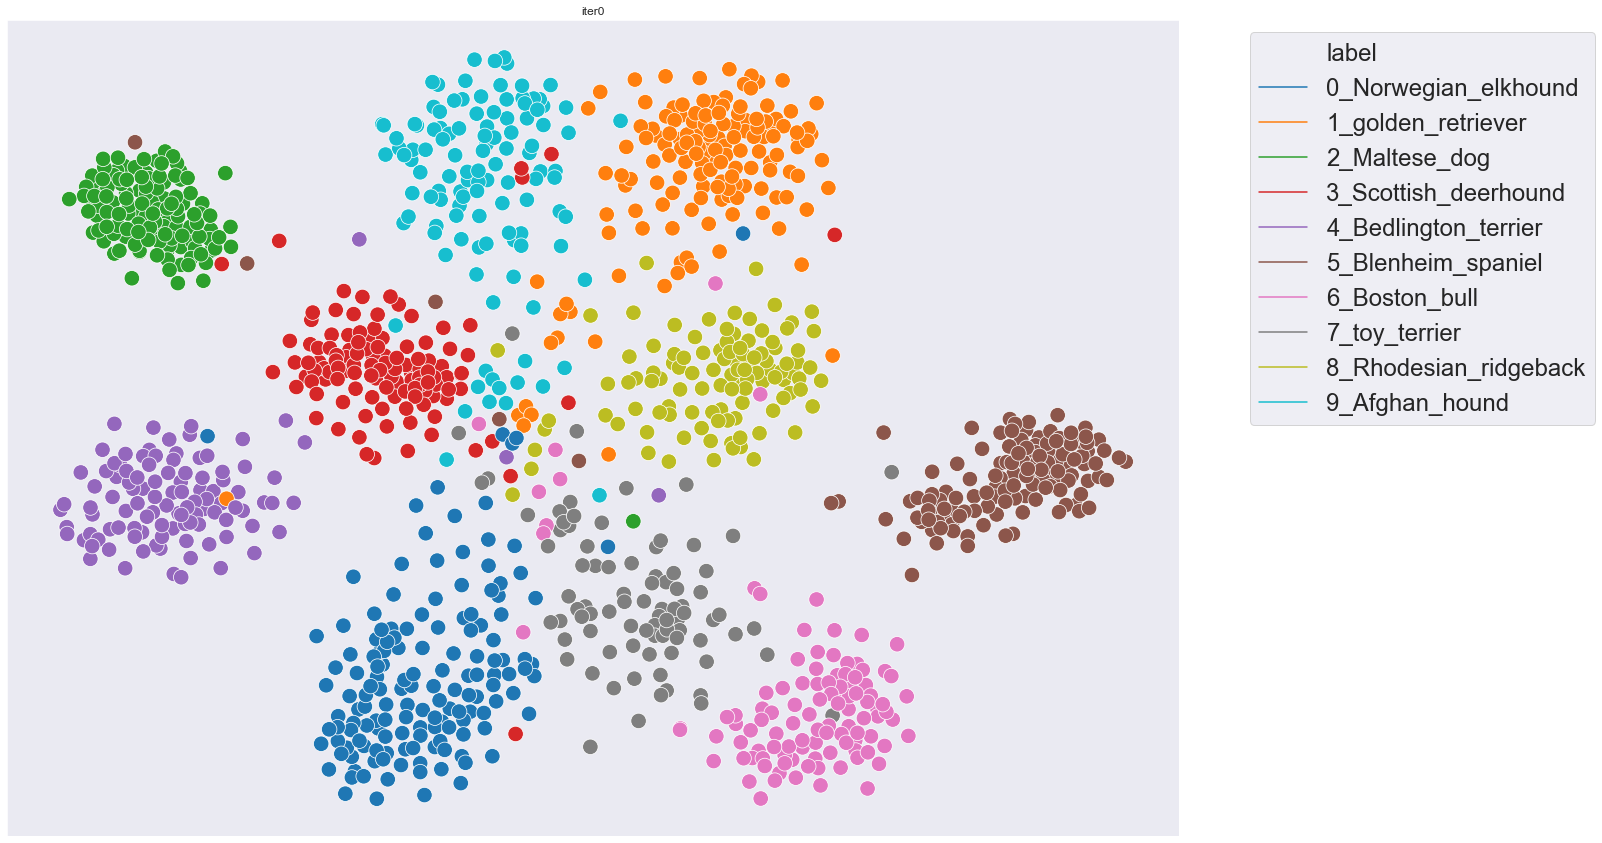

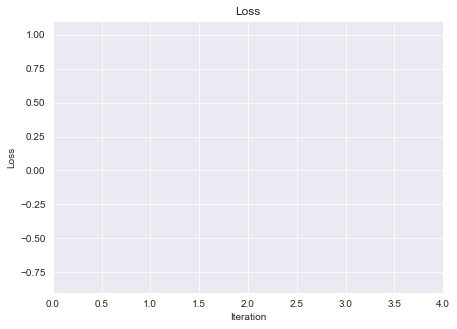

In [21]:
tsne_low_dim = tsne_amap.fit_transform(X,y)

# Our Blobs

In [5]:
amap = AMAP(learning_rate=0.5, 
            n_iter=91, 
            batch_size=1,
            anchors_method='birch',
            birch_threshold=35,
            umap_n_neighbors=15,
            dataset='VGGAnimals',
            class_to_label=ds.class_to_label,
            show_fig=True,
            save_fig=True,
            k=20,
            random_state=RANDOM_STATE,
            save_fig_every=90,
            magnitude_step=True,
            top_greedy=5,
            show_anchors=False,
            supervised=False,
            alpha=[1,1,0,1,1,1,1,1,1,1],
            douglas_peucker_tolerance=1,
            smooth_iter=3,
            show_relations=True,
            show_inner_blobs=True,
            random_points_method='voronoi',
            orig_images=ds.orig_images,
            annotate_images=False,
            stop_criteria=0,
            mask_sparse_subcluster=3,
            only_inter_relations=False,
            mask_relation_in_same_label=True)
print(amap)


AMAP
addr:@de108
verbose=True
n_components=2
anchors_method='birch'
n_intra_anchors=None
birch_threshold=35
birch_branching_factor=None
dim_reduction_algo='umap'
supervised=False
umap_n_neighbors=15
umap_min_dist=1
reduce_all_points=False
uniform_points_per='anchor'
k=20
proximity_k=3
self_relation=False
radius_q=None
do_relaxation=True
top_greedy=5
magnitude_step=True
n_iter=91
batch_size=1
stop_criteria=0
loss_func=<function AMAP.l_inf_loss at 0x00000128744525E8>
loss='Linf'
only_inter_relations=False
learning_rate=0.5
mask_sparse_subcluster=3
random_points_method='voronoi'
class_to_label={0: 'Norwegian_elkhound', 1: 'golden_retriever', 2: 'Maltese_dog', 3: 'Scottish_deerhound', 4: 'Bedlington_terrier', 5: 'Blenheim_spaniel', 6: 'Boston_bull', 7: 'toy_terrier', 8: 'Rhodesian_ridgeback', 9: 'Afghan_hound'}
random_state=42
n_jobs=None
dataset='VGGAnimals'
show_fig=True
save_fig=True
is_plotly=False
do_animation=False
use_spline=False
alpha=[1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
douglas_peucker

finding intra class anchors using birch
UnSupervised Dim Reduction
Dim Reduction only anchors
Dim Reduction only anchors - generate random points in low dim per anchor


 37%|█████████████████████████████▏                                                | 644/1719 [00:01<00:02, 449.65it/s]

anchor 154 has no voronoi region, why? returning anchor instead of random point - probably not error


100%|█████████████████████████████████████████████████████████████████████████████| 1719/1719 [00:02<00:00, 713.92it/s]


Starting iteration 1 loss = 0.6
src: 150 target 235 dir -1 density 28loss: -0.6
src: 150 target 216 dir -1 density 28loss: -0.26666666666666666
src: 471 target 158 dir 1 density 9loss: 0.26282051282051283
src: 158 target 233 dir -1 density 31loss: -0.2465753424657534
src: 28 target 158 dir 1 density 5loss: 0.2403846153846154
Skipping polygon of label 0 with area 0.00016719116717212046
Skipping polygon of label 3 with area 0.00016719116717212046
Skipping polygon of label 3 with area 0.0001671871811153025
Skipping polygon of label 6 with area 0.00016719116717212046
Skipping polygon of label 6 with area 0.0001671871811153025
Skipping polygon of label 6 with area 0.0001671871811153025
Skipping polygon of label 8 with area 0.00016719116717212046


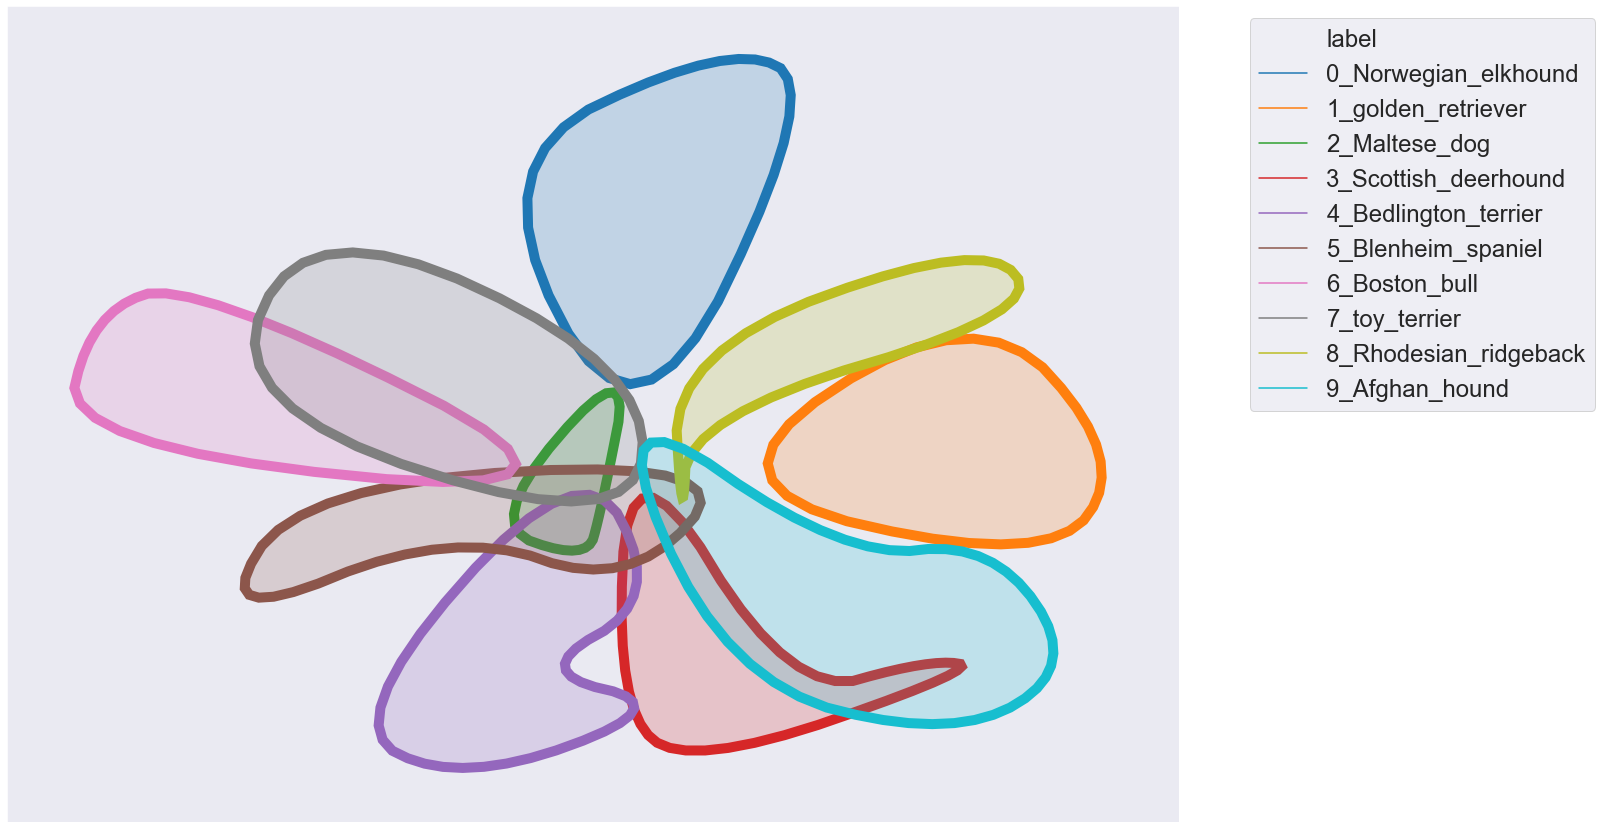

Skipping polygon of label 0 with area 0.00016719116717212046
Skipping polygon of label 3 with area 0.00016719116717212046
Skipping polygon of label 3 with area 0.0001671871811153025
Skipping polygon of label 6 with area 0.00016719116717212046
Skipping polygon of label 6 with area 0.0001671871811153025
Skipping polygon of label 6 with area 0.0001671871811153025
Skipping polygon of label 8 with area 0.00016719116717212046


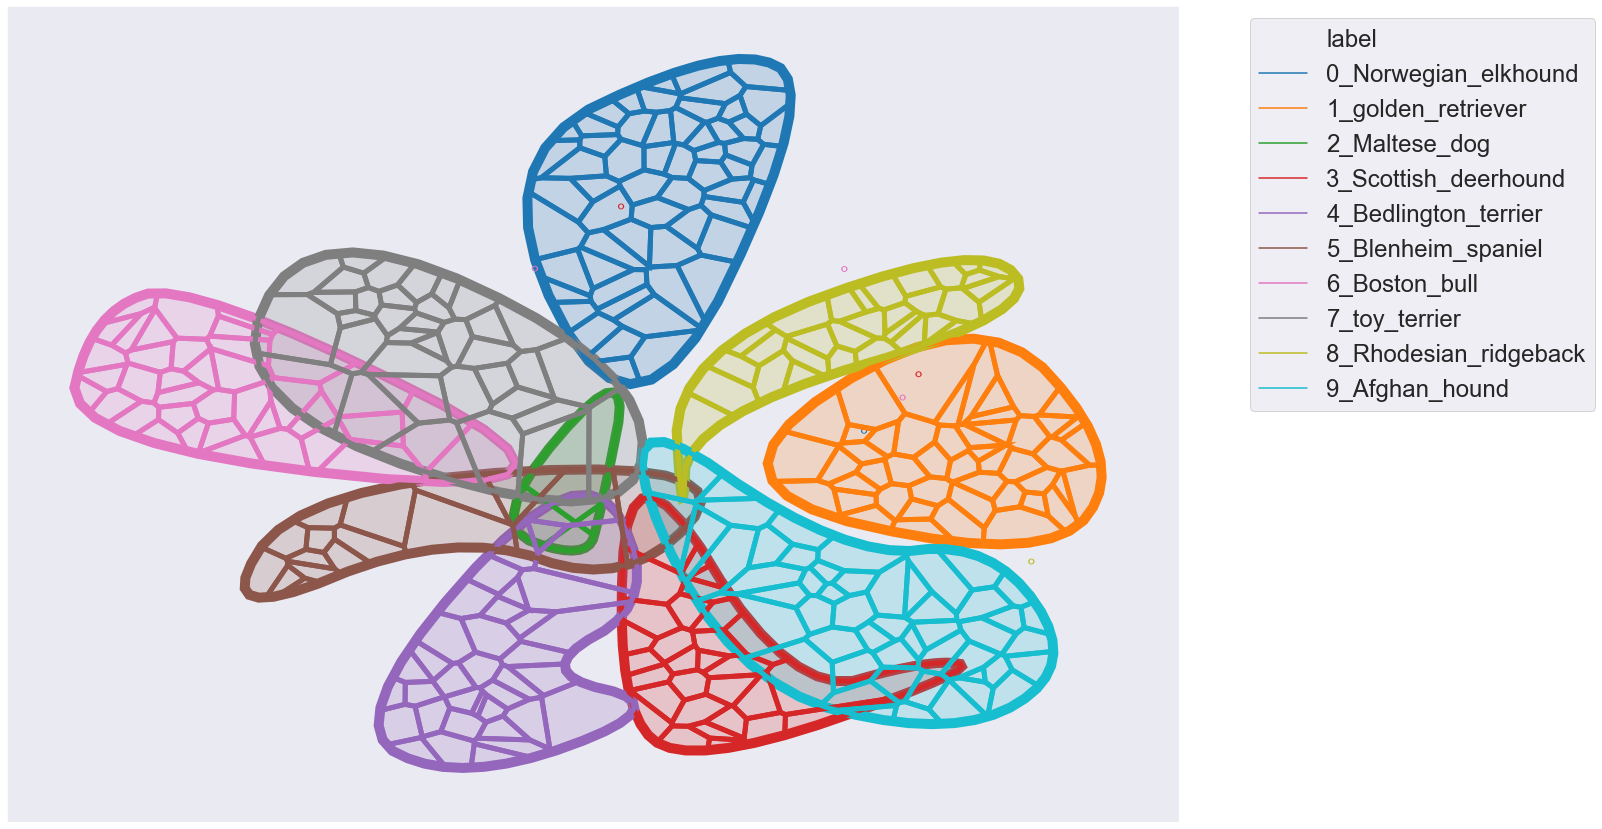

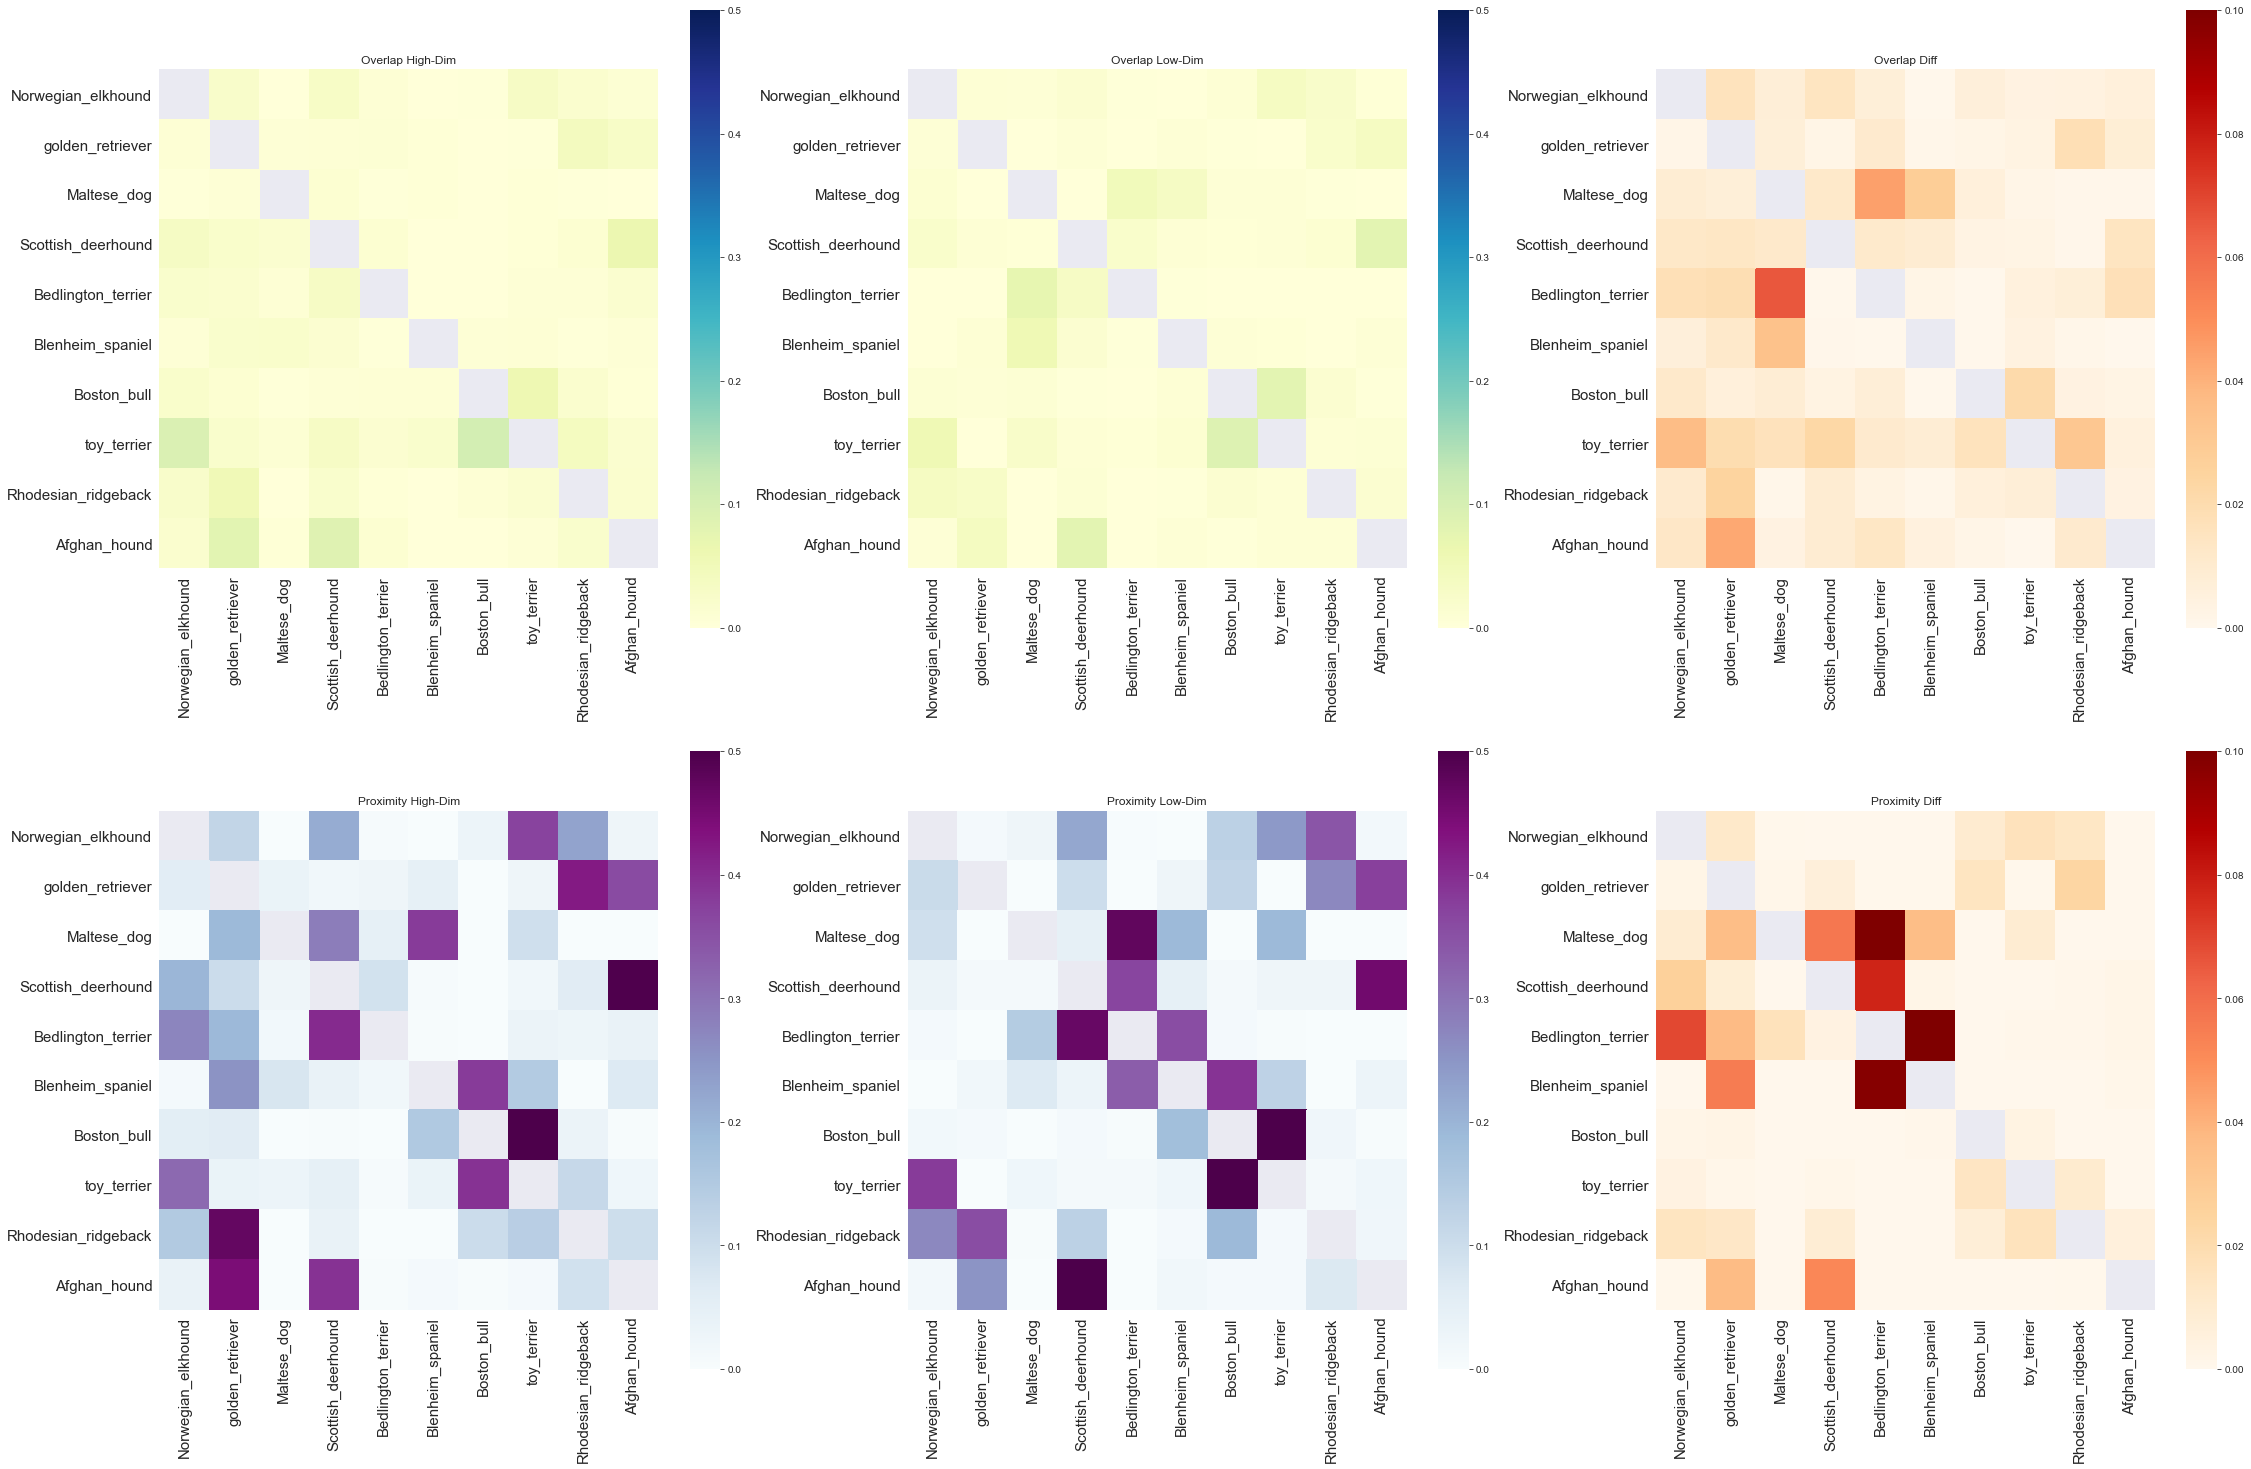

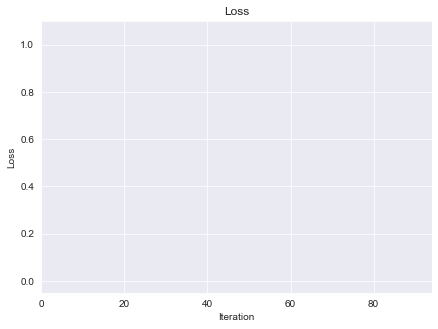

Starting iteration 2 loss = 0.6666666666666666
src: 150 target 235 dir -1 density 28loss: -0.6666666666666666
src: 158 target 233 dir -1 density 31loss: -0.24324324324324326
src: 28 target 158 dir 1 density 5loss: 0.2403846153846154
src: 471 target 158 dir 1 density 9loss: 0.23627184025414116
src: 150 target 184 dir -1 density 28loss: -0.21734892787524365
Starting iteration 3 loss = 0.4583333333333333
src: 150 target 235 dir -1 density 28loss: -0.4583333333333333
src: 150 target 184 dir -1 density 28loss: -0.42105263157894735
src: 28 target 158 dir 1 density 5loss: 0.2403846153846154
src: 149 target 263 dir -1 density 89loss: -0.21505376344086022
src: 158 target 233 dir -1 density 31loss: -0.21212121212121213
Starting iteration 4 loss = 0.31390977443609025
src: 150 target 184 dir -1 density 28loss: -0.31390977443609025
src: 28 target 158 dir 1 density 5loss: 0.2403846153846154
src: 150 target 235 dir -1 density 28loss: -0.21428571428571427
src: 149 target 222 dir -1 density 89loss: -0.

src: 162 target 150 dir -1 density 3loss: -0.19117647058823528
src: 150 target 196 dir -1 density 28loss: -0.19047619047619047
Starting iteration 48 loss = 0.43478260869565216
src: 150 target 160 dir -1 density 28loss: -0.43478260869565216
src: 159 target 150 dir -1 density 9loss: -0.3333333333333333
src: 156 target 150 dir -1 density 9loss: -0.23577235772357724
src: 149 target 230 dir -1 density 89loss: -0.2265193370165746
src: 149 target 263 dir -1 density 89loss: -0.22099447513812154
Starting iteration 49 loss = 0.40816326530612246
src: 150 target 160 dir -1 density 28loss: -0.40816326530612246
src: 159 target 150 dir -1 density 9loss: -0.35537190082644626
src: 156 target 150 dir -1 density 9loss: -0.3114754098360656
src: 150 target 156 dir -1 density 28loss: -0.22448979591836735
src: 149 target 230 dir -1 density 89loss: -0.21739130434782608
Starting iteration 50 loss = 0.45098039215686275
src: 150 target 160 dir -1 density 28loss: -0.45098039215686275
src: 159 target 150 dir -1 de

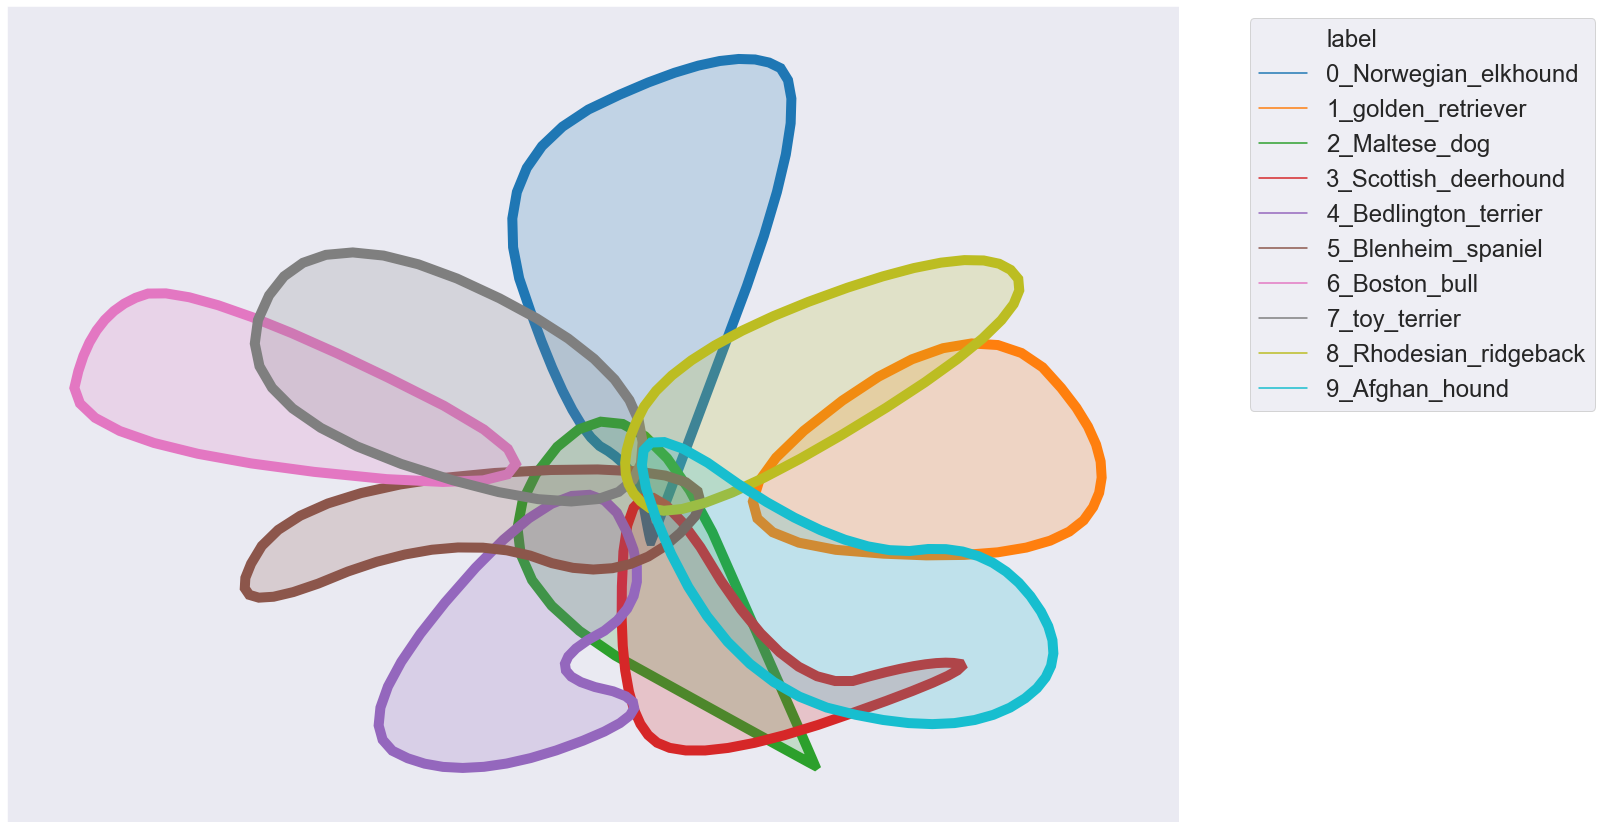

Skipping polygon of label 0 with area 0.00016719116717212046
Skipping polygon of label 3 with area 0.00016719116717212046
Skipping polygon of label 3 with area 0.0001671871811153025
Skipping polygon of label 6 with area 0.00016719116717212046
Skipping polygon of label 6 with area 0.0001671871811153025
Skipping polygon of label 6 with area 0.0001671871811153025
Skipping polygon of label 8 with area 0.00016719116717212046


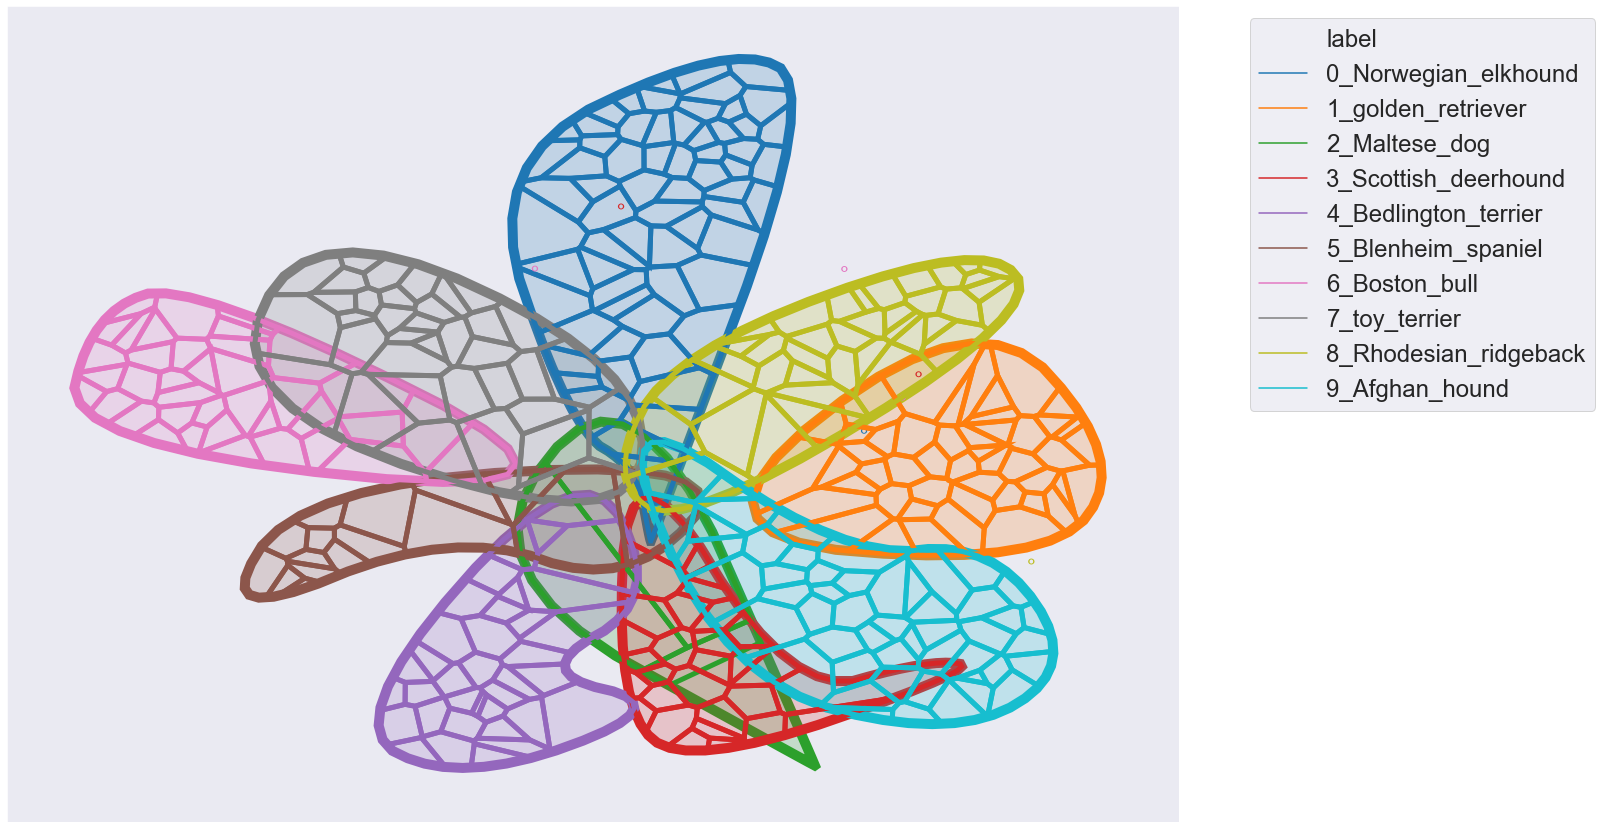

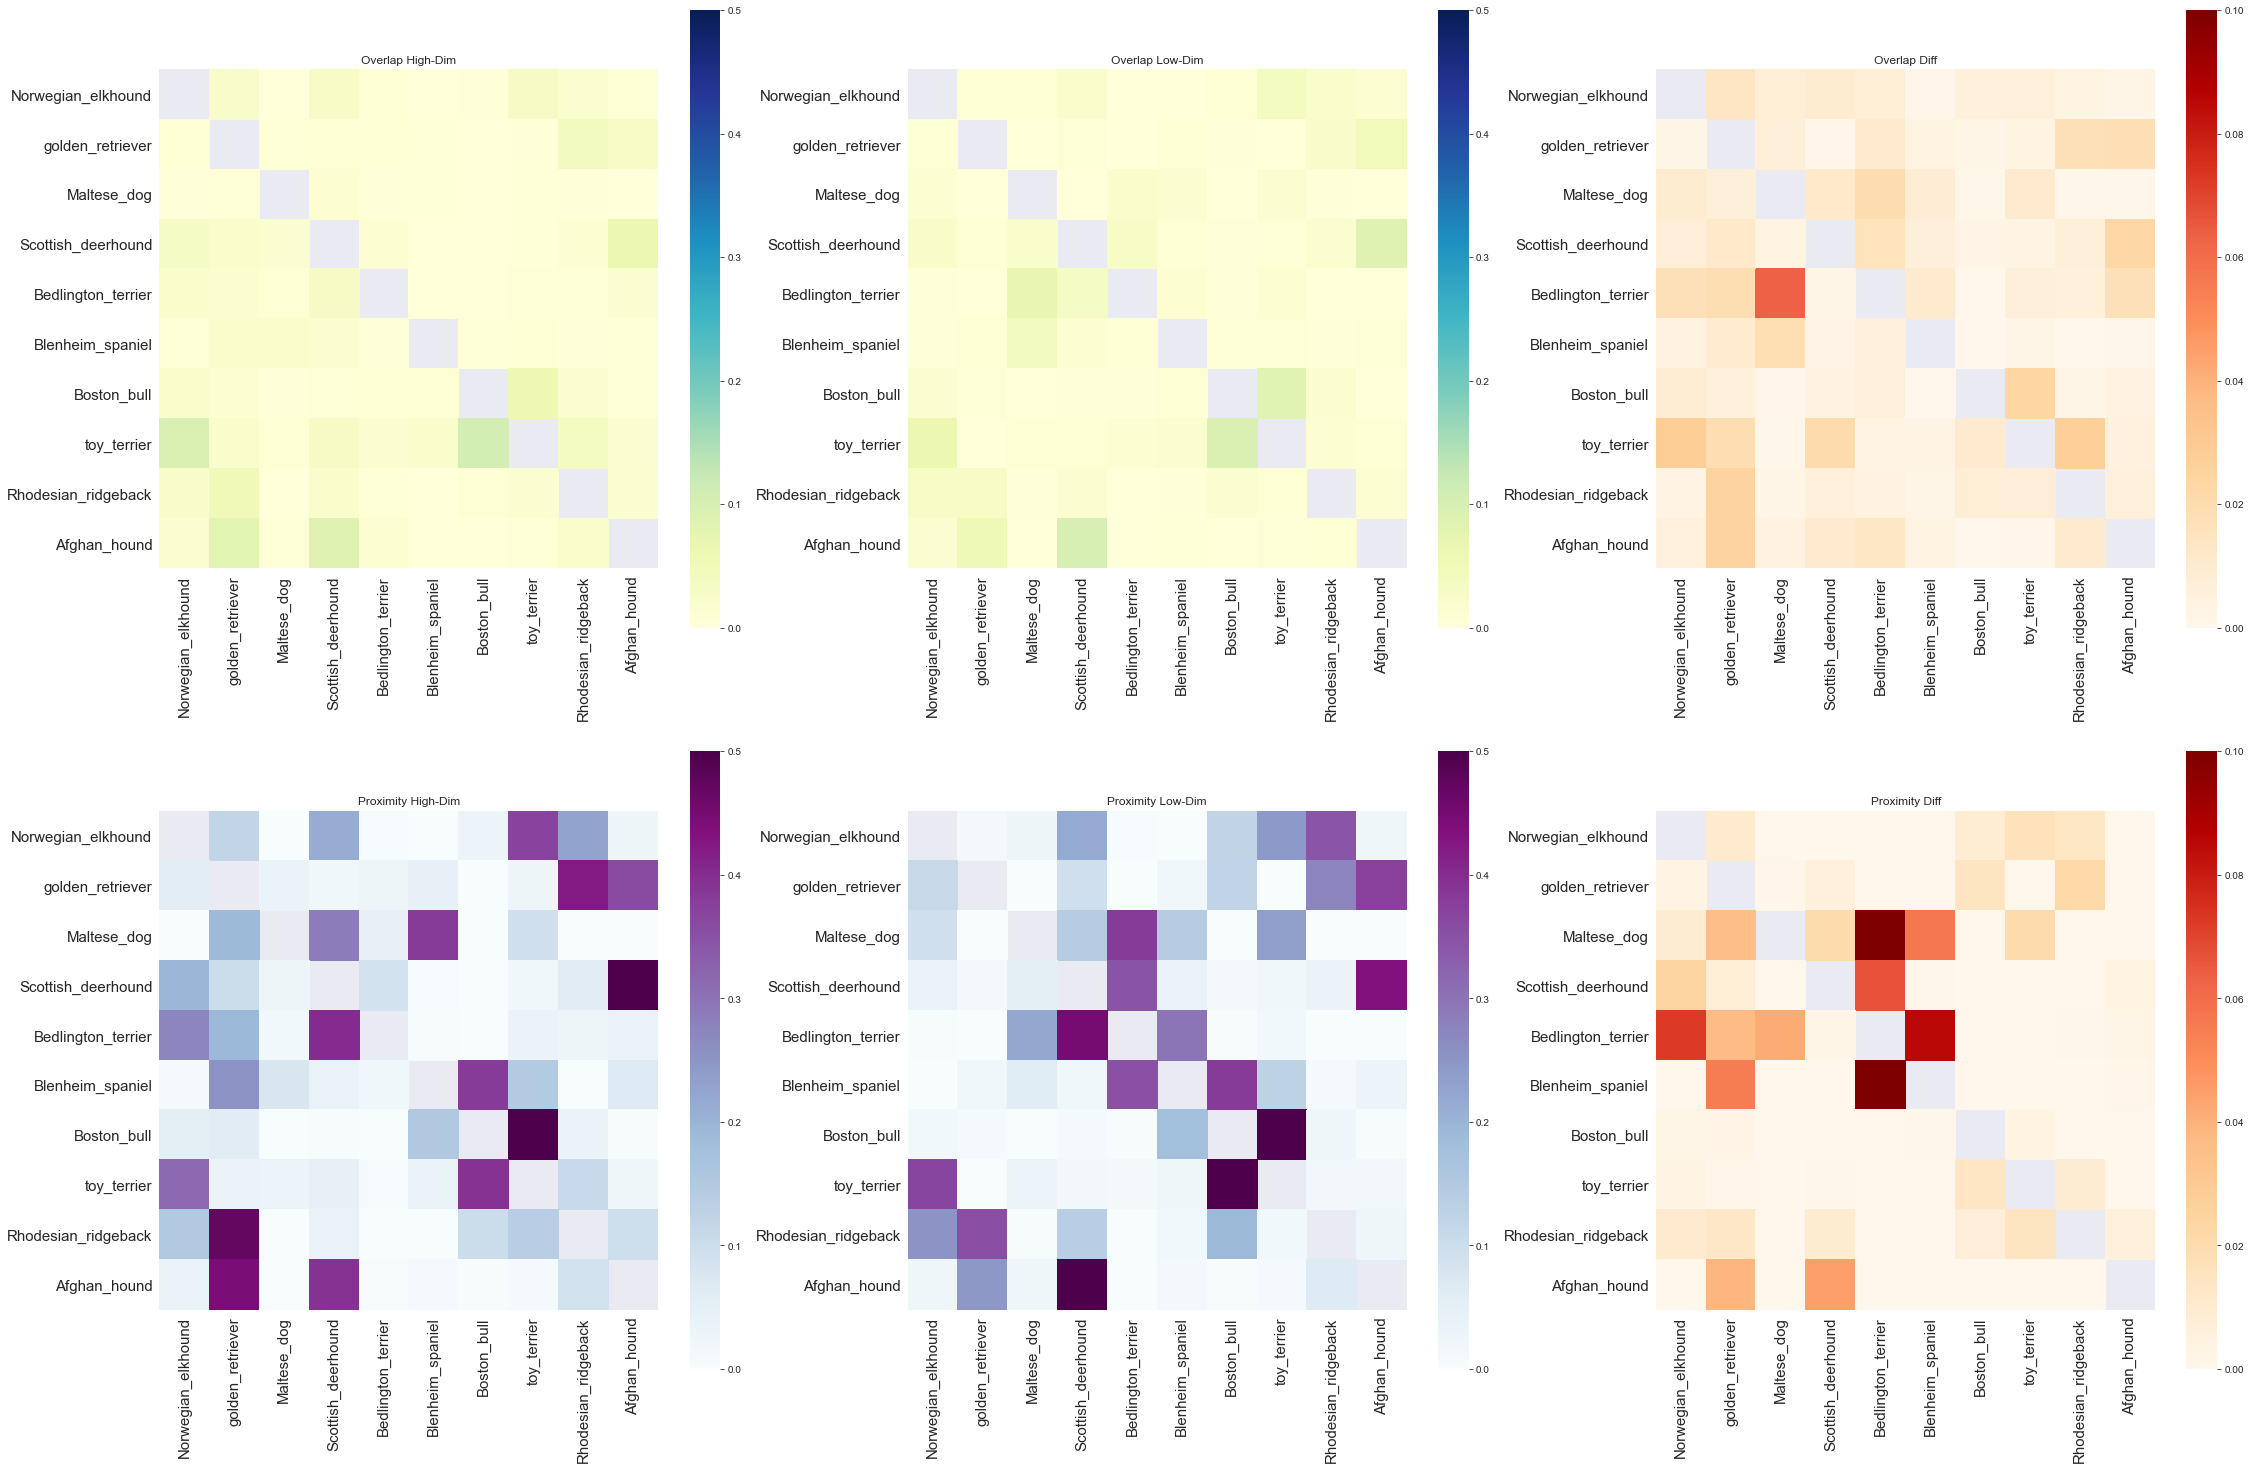

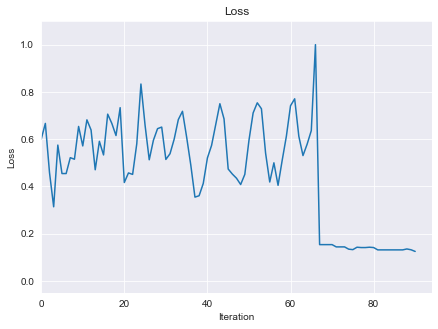

In [6]:
low_dim = amap.fit_transform(X, y)

In [9]:
a = amap.inter_class_relations - amap.inter_class_relations_low_dim

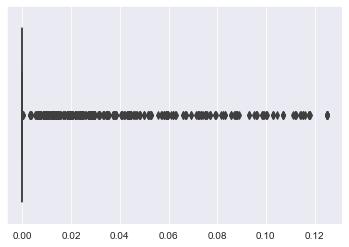

In [18]:
sns.boxplot(abs(a.flatten()))

In [19]:
np.clip(np.square(amap.inter_class_relations_label_level - amap.inter_class_relations_low_dim_label_level),
                    a_min=0,
                    a_max=0.1)

array([[           nan, 2.04450327e-04, 6.25045657e-05, 9.08739619e-05,
        6.63604396e-05, 1.61445680e-06, 3.75517725e-05, 3.84999393e-05,
        1.26489369e-05, 2.73661524e-06],
       [3.71545766e-06,            nan, 5.28669264e-05, 1.90215395e-06,
        1.13722633e-04, 1.35681424e-05, 5.46286037e-06, 1.50377035e-05,
        2.98387006e-04, 3.35435750e-04],
       [9.23922072e-05, 5.38155364e-05,            nan, 1.34221248e-04,
        4.00330587e-04, 7.14262892e-05, 1.33341156e-06, 1.15796460e-04,
        1.36101055e-06, 1.33066721e-06],
       [5.59646847e-05, 1.44865356e-04, 1.25546473e-05,            nan,
        2.48835002e-04, 5.26793684e-05, 7.35820347e-06, 1.04369723e-05,
        4.87104904e-05, 5.29563436e-04],
       [3.00413630e-04, 3.55104669e-04, 4.04758505e-03, 4.02637128e-06,
                   nan, 1.21300646e-04, 3.24404995e-07, 4.35867809e-05,
        3.59595021e-05, 2.98386562e-04],
       [1.66126593e-05, 1.01782743e-04, 3.38600212e-04, 7.05133230e-06,
   